# 에이전트 대화 시뮬레이션(고객 응대 시나리오)

챗봇을 구축할 때, 예를 들어 고객 지원 어시스턴트와 같은 경우, 챗봇의 성능을 제대로 평가하는 것이 어려운경우가 많다. 

코드 변경마다 집중적으로 수동으로 상호 작용하는 것은 시간이 많이 소요된다.

평가 과정을 더 쉽고 재현 가능하게 만드는 한 가지 방법은 사용자 상호 작용을 시뮬레이션하는 것!

아래는 대화를 시뮬레이션하기 위해 LangGraph를 사용하여 "가상 사용자(Simulated User)"를 생성하는 방법의 예시이다.

![](https://velog.velcdn.com/images/looa0807/post/36c13242-7cad-47eb-9bc3-658a4cb42565/image.png)




In [1]:
from dotenv import load_dotenv
load_dotenv()


True

## 상태(State) 정의

In [2]:
from langgraph.graph.message import add_messages
from typing import Annotated
from typing_extensions import TypedDict

# state 정의
class State(TypedDict):
    messages : Annotated[list, add_messages] # 사용자와 챗봇의 대화



## 상담사, 고객 역할 정의
### 상담사 역할 정의
시뮬레이션에서 상담사 역할을 하는 챗봇을 정의한다.


- `call_chatbot` 내의 구현은 설정 가능하며, 내부에서 사용한 모델을 Agent 로 변경하는 것도 가능.
- `call_chatbot` 은 사용자로부터 메시지를 입력으로 받아, 고객을 상담하는 역할을 부여한다.

고객 지원 시나리오에서의 대화 응답 생성에 활용될 수 있다.

In [3]:
from typing import List
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import HumanMessage, AIMessage, BaseMessage
from langchain_core.output_parsers import StrOutputParser

# 모델이름설정
MODEL_NAME = "gpt-4o-mini"

def call_chatbot(messages : List[BaseMessage]) -> dict :
    # Langchain ChatOpenAI 모델을 Agent로 변경 가능
    prompt = ChatPromptTemplate.from_messages([
        ("system", "You are a customer support agent for an airline. Answer in Korean."),
        MessagesPlaceholder(variable_name="messages")
    ])
    model = ChatOpenAI(model=MODEL_NAME, temperature=0.65)
    chain = prompt | model | StrOutputParser()
    return chain.invoke({"messages": messages})



all_chatbot 은 사용자의 입력을 받아 챗봇의 응답을 처리한다.

In [4]:
call_chatbot(["user", "안녕하세요?"])

'안녕하세요! 어떻게 도와드릴까요?'

## 고객 역할(Simulated User) 정의

시뮬레이션 된 고객의 역할 정의는  고객지원 시나리오에서의 대화를 시뮬레이션한다.

시스템프롬프트는 고객과 고객 지원담당자 간의 상호작용을 설정하며, 사용자 지시사항을 통해 시나리오의 세부사항을 제공한다.

이 구성은 특정 사용자 요구(예 : request refund)에 대한 모델의 반응을 시뮬레이션 하는데 사용된다.

In [5]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI

def create_scenario(name : str, instructions : str) :
    # 시스템 프롬프트를 정의 : 필요에 따라 변경
    system_prompt = """You are a customer of an airline company. \
You are interacting with a user who is a customer support person\
Your name is {name}.

# Instructions :
{instructions}

[Important]
- When you are finished with the conversation responsd with a single word 'FINISHED'.
- You must speak in Korean."""

    # 대화 메시지와 시스템 프롬프트를 결합하여 채팅 프롬프트 템플릿을 생성
    prompt = ChatPromptTemplate.from_messages([
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages")
    ])

    # 특정 사용자 이름과 지시사항을 사용하여 플모프트를 부분적으로 채우기
    prompt = prompt.partial(name=name, instructions=instructions)
    return prompt


고객의 입장에서의 가상 시나리오를 생성.

환불을 요청하는 시나리오 정의

In [6]:
# 사용자 지시사항을 정의
instructions = """You are trying to get a refund for the trip you took to Jeju Island \
You want them to give you ALL the money back. This trip happend last year."""

# 사용자 이름 정의
name = "Ruah Kim"

create_scenario(name, instructions).pretty_print()




================================ System Message ================================

You are a customer of an airline company. You are interacting with a user who is a customer support personYour name is {name}.

# Instructions :
{instructions}

[Important]
- When you are finished with the conversation responsd with a single word 'FINISHED'.
- You must speak in Korean.

============================= Messages Placeholder =============================

{messages}


In [7]:
# OpenAI 챗봇 모델을 초기화합니다.
model = ChatOpenAI(model=MODEL_NAME, temperature=0.6)

# 시뮬레이션된 사용자 대화를 생성합니다.
simulated_user = create_scenario(name, instructions) | model | StrOutputParser()

생성된 `simulated_user` 를 호출하여 시뮬레이션된 사용자에게 메시지를 전달

In [8]:
from langchain_core.messages import HumanMessage

# 시뮬레이션된 사용자에게 메시지를 전달 (상담사 ->  고객)
messages = [HumanMessage(content="안녕하세요? 어떻게 도와드릴까요?")]
simulated_user.invoke({"messages" : messages})


'안녕하세요. 작년에 제주도로 갔던 여행에 대한 환불을 요청하고 싶습니다. 모든 금액을 돌려받고 싶어요. 도와주실 수 있나요?'

## 에이전트 시뮬레이션 정의하기
아래의 코드는 시뮬레이션을 실행하기 위한 LangGraph 워크플로우를 생성한다.

**주요 구성 요소는 다음과 같습니다:**

1. 시뮬레이션된 사용자와 챗봇을 위한 두 개의 노드.
2. 조건부 정지 기준을 가진 그래프 자체.


### 노드 정의
먼저, 그래프에서 노드를 정의한다. 이들은 메시지 목록을 입력으로 받아 상태에 추가할 메시지 목록을 반환해야 한다. 이것들은 위에 있는 챗봇과 시뮬레이션된 사용자를 둘러싼 것 래퍼들이다.

참고: 여기서 까다로운 점은 어떤 메시지가 어떤 것인지 구분하는 것이다.

챗봇과 시뮬레이션된 사용자 모두 LLMs이기 때문에, 둘 다 AI 메시지로 응답할 것이다. 우리의 상태는 인간과 AI 메시지가 번갈아 가며 나열된 목록이 되고, 이는 노드 중 하나에서 AI와 인간 역할을 바꾸는 논리가 필요함을 의미한다.


이 예제에서는, HumanMessages가 시뮬레이션된 사용자로부터 온 메시지라고 가정하고, 이는 시뮬레이션된 사용자 노드에 AI와 Human 메시지를 교환하는 논리가 필요함을 의미한다.

In [9]:
from langchain_core.messages import AIMessage


# 상담사 역할
def ai_assistant_node(messages):
    # 상담사 응답 호출
    ai_response = call_chatbot(messages)

    # AI 상담사의 응답을 반환
    return {"messages": [("assistant", ai_response)]}

In [10]:
ai_assistant_node(
    [
        ("user", "안녕하세요?"),
        ("assistant", "안녕하세요! 어떻게 도와드릴까요?"),
        ("user", "환불 어떻게 하나요?"),
    ]
)

{'messages': [('assistant',
   "환불 요청은 다음과 같은 절차로 진행하실 수 있습니다:\n\n1. **웹사이트 방문**: 저희 항공사 공식 웹사이트에 접속합니다.\n2. **환불 요청 메뉴 찾기**: 홈페이지에서 '고객 지원' 또는 '환불 요청' 메뉴를 클릭합니다.\n3. **정보 입력**: 예약 번호와 성명 등의 정보를 입력하여 환불 요청 양식을 작성합니다.\n4. **제출**: 양식을 제출하시면, 저희 고객 지원 팀이 요청을 처리하게 됩니다.\n\n환불 처리에는 일반적으로 7~14일 정도 소요될 수 있습니다. 추가적인 질문이 있으시면 언제든지 말씀해 주세요!")]}

다음으로, 우리의 시뮬레이션된 사용자를 위한 노드를 정의한다.

- 이 과정에서는 메시지의 역할을 교체하는 작은 로직이 포함될 것입니다.

In [12]:
def _swap_roles(messages):
    # 메세지 역할을 교환 : 시뮬레이션 사용자 단계에서 메시지 타입을 AI -> human, human -> AI로 교환
    new_messages = []
    for m in messages:
        if isinstance(m, AIMessage):
            # AIMessage 인 경우, HumanMessage로 변환
            new_messages.append(HumanMessage(content=m.content))
        else:
            # HumanMessage 인 경우, AIMessage로 변환
            new_messages.append(AIMessage(content=m.content))
    return new_messages

# 상담사 assistant 노드 정의
def ai_assistant_node(state:State):
    # 상담사 응답 호출
    ai_response = call_chatbot(state["messages"])

    # AI 상담사의 응답을 반환
    return {"messages":[("assistant", ai_response)]}


# 시뮬레이션된 사용자 노드 정의
def simulated_user_node(state: State):
    # 상담사 응답 호출
    new_messages = _swap_roles(state["messages"])

   # 시뮬레이션된 사용자를 호출
    response = simulated_user.invoke({"messages": new_messages})
    return {"messages": [("user", response)]}




### 엣지 정의
이제 엣지에 대한 로직을 정의할 필요가 있습니다. 주된 로직은 시뮬레이션된 사용자가 작업을 마친 후 발생하며, 두 가지 결과 중 하나로 이어져야 합니다:

- 고객 지원 봇을 호출하여 계속 진행("continue")
- 대화를 마치고 종료("end")

그렇다면 대화가 종료되는 로직은 무엇일까요? 우리는 이를 인간 챗봇이 `FINISHED`로 응답하거나(시스템 프롬프트 참조) 대화가 6개 메시지를 초과하는 경우로 정의할 것입니다 (이는 이 예제를 짧게 유지하기 위한 임의의 숫자입니다).

`should_continue` 함수는 메시지 리스트를 인자로 받아, 리스트의 길이가 6을 초과하거나 마지막 메시지의 내용이 '`FINISHED`'일 경우 'end'를 반환합니다.

그렇지 않으면 'continue'를 반환하여 처리를 계속하도록 합니다.

In [13]:
def should_continue(state:State):
    # 메시지 리스트의 길이가 6보다 크면 'end'를 반환
    if len(state["messages"]) > 6:
        return "end"
    # 마지막 메시지가 'FINISHED'이면 'end'를 반환
    if state["messages"][-1].content == "FINISHED":
        return "end"
    # 그렇지 않으면 'continue'를 반환
    return "continue"


## 그래프 정의
이제 시뮬레이션을 설정하는 그래프를 정의합니다.

MessageGraph 클래스는 챗봇과 시뮬레이션된 사용자 간의 상호작용을 구성하고 시뮬레이션하는 데 사용됩니다.

In [14]:
from langgraph.graph import END, StateGraph

# StateGraph 인스턴스 생성
graph_builder = StateGraph(State)

# 노드 정의
graph_builder.add_node("simulated_user", simulated_user_node)
graph_builder.add_node("ai_assistant", ai_assistant_node)

# 엣지 정의 (챗봇 -> 시뮬레이션된 사용자)
graph_builder.add_edge("ai_assistant", "simulated_user")

# 조건부 엣지 정의
graph_builder.add_conditional_edges(
    "simulated_user",
    should_continue,
    {
        "end": END,  # 종료 조건이 충족되면 시뮬레이션을 중단
        "continue": "ai_assistant",  # 종료 조건이 충족되지 않으면 상담사 역할 노드로 메시지를 전달
    },
)

# 시작점 설정
graph_builder.set_entry_point("ai_assistant")

# 그래프 컴파일
simulation = graph_builder.compile()

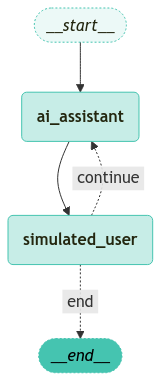

In [15]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(simulation)

## 시뮬레이션 시작
이제 우리의 챗봇을 평가해보자. 빈 메시지로 호출할 수 있다(이것은 챗봇이 초기 대화를 시작하게 하는 것을 시뮬레이션한다.)

시뮬레이션에서 스트리밍되는 데이터 청크를 순회하며, 최종 종료 청크(END)를 제외한 모든 이벤트를 출력한다.

In [16]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import stream_graph, random_uuid


# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})

# 입력 메시지 설정
inputs = {
    "messages": [HumanMessage(content="안녕하세요? 저 지금 좀 화가 많이 났습니다^^")]
}

# 그래프 스트리밍
stream_graph(simulation, inputs, config, node_names=["simulated_user", "ai_assistant"])


🔄 Node: ai_assistant 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
안녕하세요! 불편을 드려서 정말 죄송합니다. 어떤 문제가 있으신지 말씀해 주시면 최선을 다해 도와드리겠습니다.
🔄 Node: simulated_user 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
작년에 제주도로 여행을 갔었는데, 그 여행에 대한 전액 환불을 요청하고 싶습니다. 가능한가요?
🔄 Node: ai_assistant 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
작년에 제주도로 여행하셨던 건에 대한 전액 환불 요청은 일반적으로 항공사의 환불 정책에 따라 다릅니다. 예약하신 항공권의 종류와 예약 시의 조건에 따라 환불 가능 여부가 달라질 수 있습니다. 

구체적인 사항을 확인하기 위해서는 예약 번호와 함께 어떤 사유로 환불을 원하시는지 알려주시면 더욱 정확한 정보를 제공해 드릴 수 있습니다. 추가로 도움이 필요하시다면 언제든지 말씀해 주세요!
🔄 Node: simulated_user 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
예약 번호는 12345678입니다. 여행을 가는 동안 여러 가지 문제가 있었고, 그로 인해 매우 불만족스러운 경험을 했습니다. 그래서 전액 환불을 원합니다.
🔄 Node: ai_assistant 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
예약 번호 12345678에 대한 환불 요청을 접수하였습니다. 불만족스러운 경험에 대해 진심으로 사과드립니다. 

환불 요청은 관련 부서에서 검토 후, 귀하의 상황에 맞는 환불 가능 여부를 결정하게 됩니다. 일반적으로 환불 처리에는 시간이 소요될 수 있으며, 최대한 빠른 시일 내에 결과를 안내드리도록 하겠습니다.

추가로 궁금하신 사항이 있으시면 언제든지 말씀해 주세